# Tahoe Healthcare CareTracker - ML - Carles Poles-Mielgo

In [ ]:
reset -fs

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import label_binarize, MultiLabelBinarizer, binarize, FunctionTransformer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
sns.set_style('white')

In [4]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.
    Draws confusion matrix with associated metrics.
    
    Minimum required imports:
    
    import matplotlib.pyplot as plt
    import numpy as np
    Source: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    
    """
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show();

In [2]:
def classification_metrics(model_string, y_test, y_pred):
    """
    This function prints different metrics to evaluate a model. Metrics are calculated using
    sklearn package: roc_auc_score, accuracy_score, precision_score, recall_score, f1_score and classification report.
    """
    print("Precision Score of " + model_string + " model: {:.2%}\n".format(precision_score(y_test, y_pred)))
    print("AUC: {:.2%}\n".format(roc_auc_score(y_test, y_pred)))
    print("Accuracy Score of " + model_string + " model: {:.2%}\n".format(accuracy_score(y_test, y_pred)))
    print("Recall Score of " + model_string + " model: {:.2%}\n".format(recall_score(y_test, y_pred)))
    print("F1 Score of " + model_string + " model: {:.2%}\n".format(f1_score(y_test, y_pred)))
    print("Classification Report of " + model_string + ":\n\n", classification_report(y_test, y_pred))

In [25]:
def plot_roc(y_test, y_prediction, model_label, plot_title):
    """
    The function takes as parameters the test labels (observations), the test predictions and 
    two strings to customize the plot: the name of the model, and a title for the plot.
    It relies on sklearn.metrics.roc_curve to extract fpr and tpr to make the plot.
    IMPORTANT: the predictions must be probabilities in order to plot the curve: not .predict(X_test), but .predict_proba(X_test)
    """
    fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
    plt.plot(fpr, tpr, label=model_label)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.plot([0, 1], [0, 1], 'k--', color="red", label="Random guess")
    plt.legend(loc='best')
    plt.grid()
    plt.title("ROC Curve - " + plot_title + "");

In [6]:
hospital_df = pd.read_csv("Final Project Data_Case.csv")

In [7]:
new_columns = ['age', 'sex', 'flu_season', 'ed_admit', 'severity_score', 'comorbidity_score', 'readmit_30']

In [8]:
hospital_df.columns = new_columns

In [9]:
hospital_df.head()

,age,sex,flu_season,ed_admit,severity_score,comorbidity_score,readmit_30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


In [12]:
# Features.
X = hospital_df.values[:,0:(hospital_df.values.shape[1]-1)]
# Labels.
y = hospital_df.values[:,-1]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Classification Model using Logistic Regression.

In [16]:
logistic_grid = {'penalty': ['l2'],
                      'solver':['newton-cg','lbfgs', 'liblinear'],
                      'max_iter': [100,200],
                      'random_state': [1]}

In [17]:
logistic_grid_search = GridSearchCV(LogisticRegression(),
                             logistic_grid,
                             #n_jobs=-1,
                             verbose=False,
                             scoring='f1')

In [18]:
logistic_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'random_state': [1], 'max_iter': [100, 200], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=False)

In [19]:
print("Best parameters:", logistic_grid_search.best_params_)

Best parameters: {'random_state': 1, 'penalty': 'l2', 'max_iter': 100, 'solver': 'liblinear'}


In [50]:
print("Best estimator:", logistic_grid_search.best_estimator_)

Best estimator: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [20]:
best_logistic_model = logistic_grid_search.best_estimator_

In [21]:
best_logistic_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
logistic_predictions = best_logistic_model.predict(X_test)

In [23]:
logistic_predictions_probability = best_logistic_model.predict_proba(X_test)

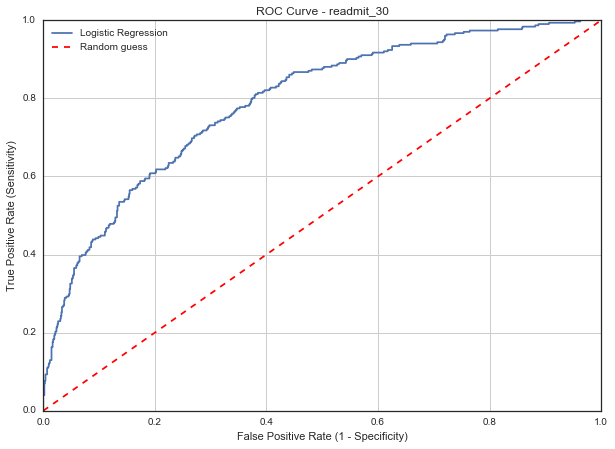

In [51]:
plt.figure(figsize=(10, 7))
plot_roc(y_test, logistic_predictions_probability[:,1], "Logistic Regression", "readmit_30")

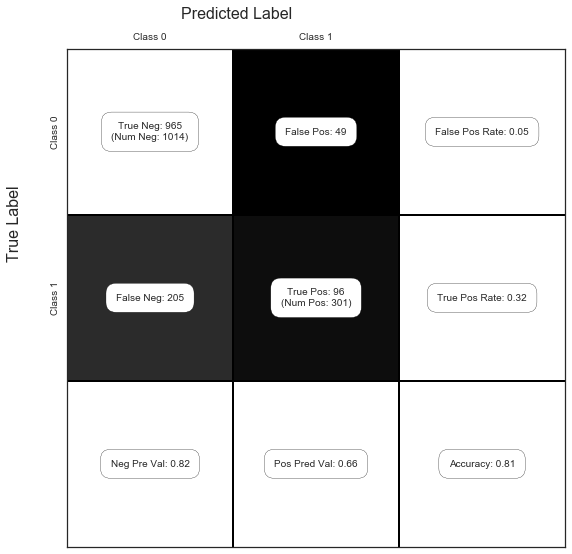

In [29]:
show_confusion_matrix(confusion_matrix(y_test, logistic_predictions), ['Class 0', 'Class 1'])

In [30]:
classification_metrics("Logistic Regression", y_test, logistic_predictions)

Precision Score of LogisticRegression model: 66.21%

AUC: 63.53%

Accuracy Score of LogisticRegression model: 80.68%

Recall Score of LogisticRegression model: 31.89%

F1 Score of LogisticRegression model: 43.05%

Classification Report of LogisticRegression:

              precision    recall  f1-score   support

          0       0.82      0.95      0.88      1014
          1       0.66      0.32      0.43       301

avg / total       0.79      0.81      0.78      1315



## Classification Model using Random Forest.

In [37]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'criterion': ['gini', 'entropy'],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20],
                      'random_state': [1]}

In [39]:
random_forest_grid_search = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             #n_jobs=-1,
                             verbose=False,
                             scoring='f1')

In [40]:
random_forest_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'random_state': [1], 'n_estimators': [10, 20], 'max_depth': [3, None], 'bootstrap': [True, False], 'max_features': ['sqrt', 'log2', None], 'min_samples_leaf': [2, 4], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=False)

In [41]:
print("Best parameters:", random_forest_grid_search.best_params_)

Best parameters: {'random_state': 1, 'n_estimators': 20, 'max_depth': None, 'bootstrap': False, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'criterion': 'gini', 'min_samples_split': 2}


In [42]:
print("Best estimator:", random_forest_grid_search.best_estimator_)

Best estimator: RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)


In [52]:
best_random_forest_model = random_forest_grid_search.best_estimator_

In [53]:
best_random_forest_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

In [54]:
random_forest_predictions = best_random_forest_model.predict(X_test)

In [55]:
random_forest_predictions_probability = best_random_forest_model.predict_proba(X_test)

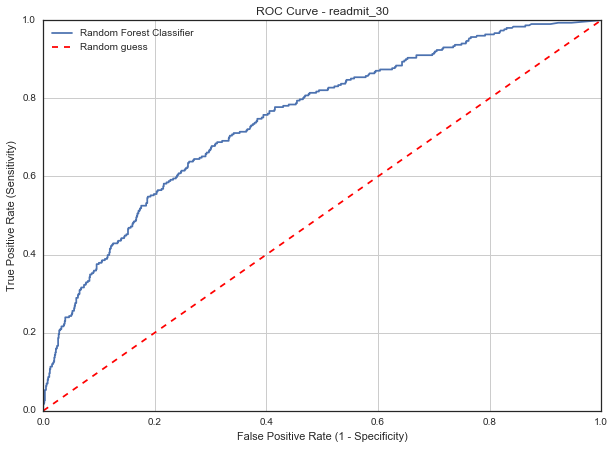

In [56]:
plt.figure(figsize=(10, 7))
plot_roc(y_test, random_forest_predictions_probability[:,1], "Random Forest Classifier", "readmit_30")

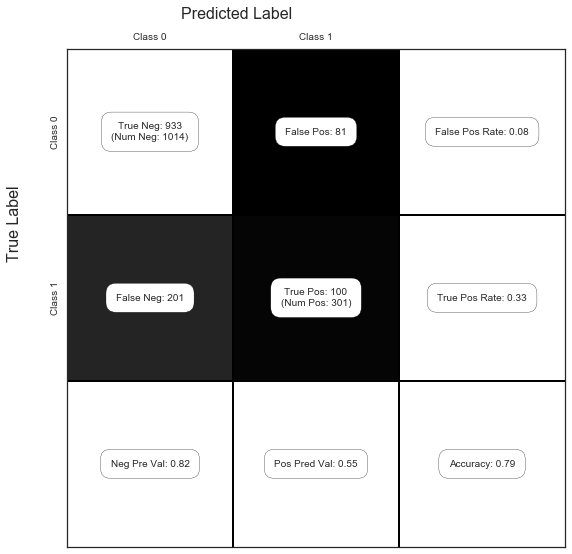

In [57]:
show_confusion_matrix(confusion_matrix(y_test, random_forest_predictions), ['Class 0', 'Class 1'])

In [58]:
classification_metrics("Random Forest Classifier", y_test, random_forest_predictions)

Precision Score of Random Forest Classifier model: 55.25%

AUC: 62.62%

Accuracy Score of Random Forest Classifier model: 78.56%

Recall Score of Random Forest Classifier model: 33.22%

F1 Score of Random Forest Classifier model: 41.49%

Classification Report of Random Forest Classifier:

              precision    recall  f1-score   support

          0       0.82      0.92      0.87      1014
          1       0.55      0.33      0.41       301

avg / total       0.76      0.79      0.76      1315



### Feature Importance.

In [43]:
best_random_forest = random_forest_grid_search.best_estimator_

In [44]:
best_random_forest.feature_importances_

array([ 0.16804587,  0.02002304,  0.03966004,  0.01184162,  0.27029432,
        0.49013511])

In [46]:
np.argsort(best_random_forest.feature_importances_)

array([3, 1, 2, 0, 4, 5])

In [47]:
hospital_df.columns[:-1][np.argsort(best_random_forest.feature_importances_)]

Index(['ed_admit', 'sex', 'flu_season', 'age', 'severity_score',
       'comorbidity_score'],
      dtype='object')

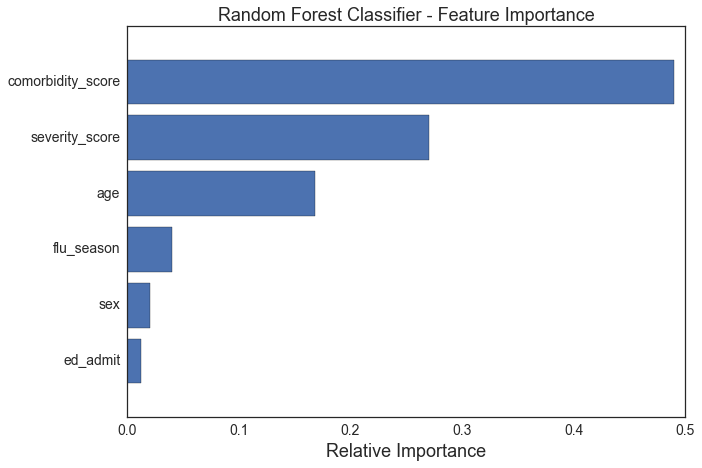

In [49]:
feature_importances_indices_rf = np.argsort(best_random_forest.feature_importances_)
figure = plt.figure(figsize=(10,7))
plt.barh(np.arange(len(hospital_df.columns[:-1])), best_random_forest.feature_importances_[feature_importances_indices_rf], align="center")
plt.yticks(np.arange(len(hospital_df.columns[:-1])), np.array(hospital_df.columns[:-1])[feature_importances_indices_rf], fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Relative Importance", fontsize=18)
plt.title("Random Forest Classifier - Feature Importance", fontsize=18);

## Classification Model using Gradient Boosting.

In [60]:
gradient_boost_grid = {'learning_rate': [0.1,0.5,1],
                      'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_leaf': [1, 2, 4],
                       'loss': ['deviance', 'exponential'],
                      'n_estimators': [20, 50],
                      'random_state': [1]}

In [61]:
gradient_boost_grid_search = GridSearchCV(GradientBoostingClassifier(),
                             gradient_boost_grid,
                             #n_jobs=-1,
                             verbose=False,
                             scoring='f1')

In [62]:
gradient_boost_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'random_state': [1], 'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.5, 1], 'max_features': ['sqrt', 'log2', None], 'min_samples_leaf': [1, 2, 4], 'n_estimators': [20, 50], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=False)

In [63]:
print("Best parameters:", gradient_boost_grid_search.best_params_)

Best parameters: {'random_state': 1, 'max_depth': None, 'learning_rate': 0.1, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 50, 'loss': 'deviance'}


In [64]:
print("Best estimator:", gradient_boost_grid_search.best_estimator_)

Best estimator: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=None,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False)


In [65]:
best_gradient_boost_model = gradient_boost_grid_search.best_estimator_

In [66]:
best_gradient_boost_model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=None,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=4,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=50, presort='auto', random_state=1,
              subsample=1.0, verbose=0, warm_start=False)

In [67]:
gradient_boost_predictions = best_gradient_boost_model.predict(X_test)

In [68]:
gradient_boost_predictions_probability = best_gradient_boost_model.predict_proba(X_test)

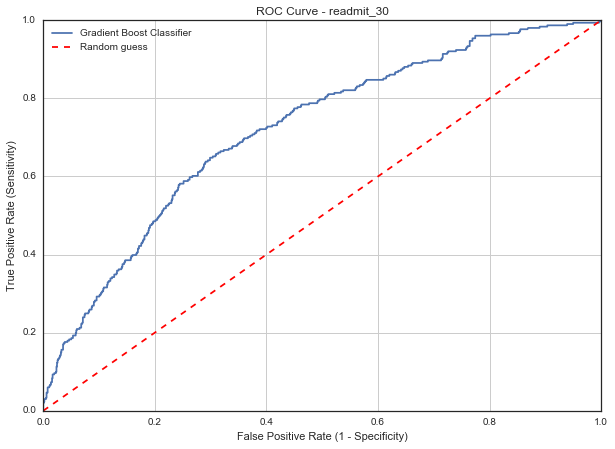

In [69]:
plt.figure(figsize=(10, 7))
plot_roc(y_test, gradient_boost_predictions_probability[:,1], "Gradient Boost Classifier", "readmit_30")

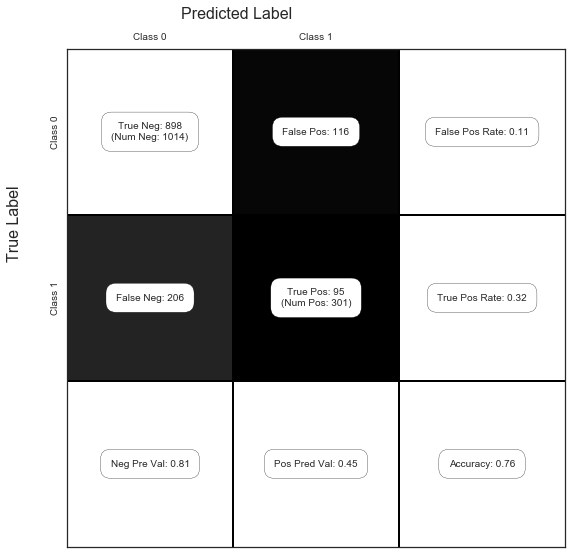

In [70]:
show_confusion_matrix(confusion_matrix(y_test, gradient_boost_predictions), ['Class 0', 'Class 1'])

In [71]:
classification_metrics("Gradient Boost Classifier", y_test, gradient_boost_predictions)

Precision Score of Gradient Boost Classifier model: 45.02%

AUC: 60.06%

Accuracy Score of Gradient Boost Classifier model: 75.51%

Recall Score of Gradient Boost Classifier model: 31.56%

F1 Score of Gradient Boost Classifier model: 37.11%

Classification Report of Gradient Boost Classifier:

              precision    recall  f1-score   support

          0       0.81      0.89      0.85      1014
          1       0.45      0.32      0.37       301

avg / total       0.73      0.76      0.74      1315



### Feature Importance.

In [72]:
best_gradient_boost = gradient_boost_grid_search.best_estimator_

In [73]:
best_gradient_boost.feature_importances_

array([ 0.24540479,  0.01894511,  0.01740315,  0.01096138,  0.27943242,
        0.42785315])

In [74]:
np.argsort(best_gradient_boost.feature_importances_)

array([3, 2, 1, 0, 4, 5])

In [75]:
hospital_df.columns[:-1][np.argsort(best_gradient_boost.feature_importances_)]

Index(['ed_admit', 'flu_season', 'sex', 'age', 'severity_score',
       'comorbidity_score'],
      dtype='object')

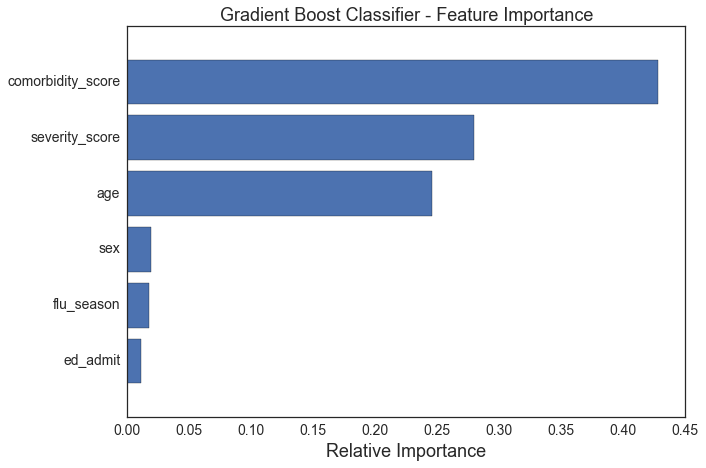

In [76]:
feature_importances_indices_rf = np.argsort(best_gradient_boost.feature_importances_)
figure = plt.figure(figsize=(10,7))
plt.barh(np.arange(len(hospital_df.columns[:-1])), best_gradient_boost.feature_importances_[feature_importances_indices_rf], align="center")
plt.yticks(np.arange(len(hospital_df.columns[:-1])), np.array(hospital_df.columns[:-1])[feature_importances_indices_rf], fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Relative Importance", fontsize=18)
plt.title("Gradient Boost Classifier - Feature Importance", fontsize=18);

## Classification Model using Naive-Bayes Multinomial.

In [77]:
naive_bayes_grid = {'alpha':[1,0.5],
                    'fit_prior': [True,False]}

In [78]:
naive_bayes_grid_search = GridSearchCV(MultinomialNB(),
                             naive_bayes_grid,
                             #n_jobs=-1,
                             verbose=False,
                             scoring='f1')

In [79]:
naive_bayes_grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'fit_prior': [True, False], 'alpha': [1, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=False)

In [80]:
print("Best parameters:", naive_bayes_grid_search.best_params_)

Best parameters: {'fit_prior': False, 'alpha': 1}


In [81]:
print("Best estimator:", naive_bayes_grid_search.best_estimator_)

Best estimator: MultinomialNB(alpha=1, class_prior=None, fit_prior=False)


In [82]:
best_naive_bayes_model = naive_bayes_grid_search.best_estimator_

In [83]:
best_naive_bayes_model.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=False)

In [84]:
naive_bayes_predictions = best_naive_bayes_model.predict(X_test)

In [85]:
naive_bayes_predictions_probability = best_naive_bayes_model.predict_proba(X_test)

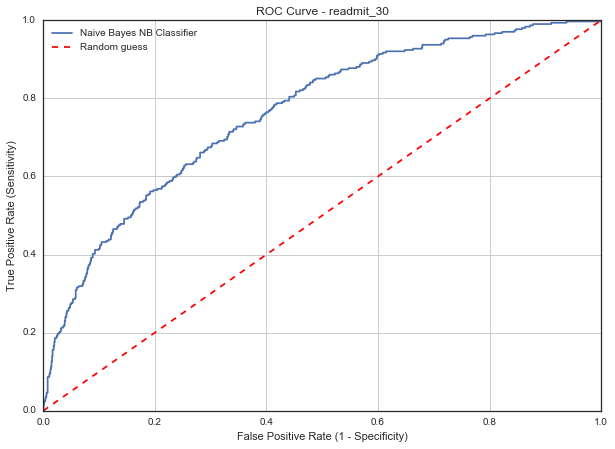

In [86]:
plt.figure(figsize=(10, 7))
plot_roc(y_test, naive_bayes_predictions_probability[:,1], "Naive Bayes NB Classifier", "readmit_30")

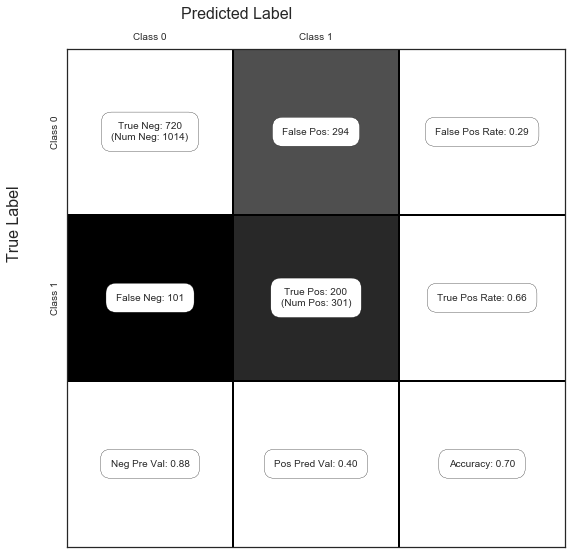

In [87]:
show_confusion_matrix(confusion_matrix(y_test, naive_bayes_predictions), ['Class 0', 'Class 1'])

In [89]:
classification_metrics("Naive Bayes NB Classifier", y_test, naive_bayes_predictions)

Precision Score of Naive Bayes NB Classifier model: 40.49%

AUC: 68.73%

Accuracy Score of Naive Bayes NB Classifier model: 69.96%

Recall Score of Naive Bayes NB Classifier model: 66.45%

F1 Score of Naive Bayes NB Classifier model: 50.31%

Classification Report of Naive Bayes NB Classifier:

              precision    recall  f1-score   support

          0       0.88      0.71      0.78      1014
          1       0.40      0.66      0.50       301

avg / total       0.77      0.70      0.72      1315

